In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, TweetTokenizer
tokenizer=TweetTokenizer()

from nltk.stem import SnowballStemmer
stemming = SnowballStemmer("english")

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizing = WordNetLemmatizer()

from sklearn import *

In [29]:
df_train=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [30]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [31]:
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In [32]:
# Checking for missing data.
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

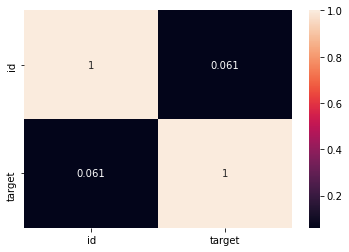

In [33]:
plt.figure()
sns.heatmap(df_train.corr(), annot=True)

In [34]:
# Distinct keyword count
dist_keyword = df_train['keyword'].value_counts()
dist_keyword

fatalities               45
armageddon               42
deluge                   42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [35]:
# Distinct location count
dist_location=df_train['location'].value_counts()
dist_location

USA                104
New York            71
United States       50
London              45
Canada              29
                  ... 
Lima, Ohio           1
Waialua, Hawaii      1
Internet             1
Kingswinford         1
midwest              1
Name: location, Length: 3341, dtype: int64

In [36]:
# Dropping location. Too many missing values! 
df_train = df_train.drop(['location'],axis=1)

In [37]:
# Dropping missing 'keyword' records from train data set
# df_train=df_train.drop(df_train[df_train['keyword'].isnull()].index,axis=0)

# # Resetting the index after droping the missing records
# df_train=df_train.reset_index(drop=True)

# print("Number of records after removing missing keywords",len(df_train))

In [38]:
short_word_dict = {
" 121 ": "one to one", " a/s/l ": "age, sex, location", " adn ": "any day now", " afaik ": "as far as I know",
" afk ": "away from keyboard", " aight ": "alright", " alol ": "actually laughing out loud", " b4 ": "before",
" b4n ": "bye for now", " bak ": "back at the keyboard", " bf ": "boyfriend", " bff ": "best friends forever", 
" bfn ": "bye for now", " bg ": "big grin", " bta ": "but then again", " btw ": "by the way", 
" cid ": "crying in disgrace", " cnp ": "continued in my next post", " cp ": "chat post", " cu ": "see you",
" cul ": "see you later", " cul8r ": "see you later", " cya ": "bye", " cyo ": "see you online",
" dbau ": "doing business as usual", " fud ": "fear, uncertainty, and doubt", " fwiw ": "for what it's worth",
" fyi ": "for your information", " g ": "grin", " g2g ": "got to go", " ga ": "go ahead", " gal ": "get a life",
" gf ": "girlfriend", " gfn ": "gone for now", " gmbo ": "giggling my butt off", " gmta ": "great minds think alike",
" h8 ": "hate", " hagn ": "have a good night", " hdop ": "help delete online predators", " hhis ": "hanging head in shame",
" iac ": "in any case", " ianal ": "I am not a lawyer", " ic ": "I see", " idk ": "I don't know",
" imao ": "in my arrogant opinion", " imnsho ": "in my not so humble opinion", " imo ": "in my opinion",
" iow ": "in other words", " ipn ": "I’m posting naked", " irl ": "in real life", " jk ": "just kidding",
" l8r ": "later", " ld ": "later, dude", " ldr ": "long distance relationship", " llta ": "lots and lots of thunderous applause",
" lmao ": "laugh my ass off", " lmirl ": "let's meet in real life", " lol ": "laugh out loud", 
" ltr ": "longterm relationship", " lulab ": "love you like a brother", " lulas ": "love you like a sister",
" luv ": "love", " m/f ": "male or female", " m8 ": "mate", " milf ": "mother I would like to fuck", 
" oll ": "online love", " omg ": "oh my god", " otoh ": "on the other hand", " pir ": "parent in room", 
" ppl ": "people", " r ": "are", " rofl ": "roll on the floor laughing", " rpg ": "role playing games",
" ru ": "are you", " shid ": "slaps head in disgust", " somy ": "sick of me yet", " sot ": "short of time",
" thanx ": "thanks", " thx ": "thanks", " ttyl ": "talk to you later", " u ": "you", " ur ": "you are",
" uw ": "you’re welcome", " wb ": "welcome back", " wfm ": "works for me", " wibni ": "wouldn't it be nice if",
" wtf ": "what the fuck", " wtg ": "way to go", " wtgp ": "want to go private", " ym ": "young man", " gr8 ": "great"
}
df_train['text'] = df_train['text'].replace(short_word_dict, regex=True)
df_test['text'] = df_test['text'].replace(short_word_dict, regex=True)

In [39]:
from html.parser import HTMLParser
html_parser = HTMLParser()

# Make the text lower
df_train['text'] = df_train['text'].str.lower()
df_test["text"] = df_test["text"].str.lower()

#Removing HTML
df_train['text'] = df_train['text'].apply(lambda x: html_parser.unescape(x))
df_test["text"] = df_test["text"].apply(lambda x: html_parser.unescape(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  # Remove the CWD from sys.path while we load stuff.


In [40]:
def text_cleaning(text):
    text = text.replace('\n',' ', regex=True)
    #replace carriage return characters
    text = text.replace('\r',' ', regex=True)
    #replace tab characters
    text = text.replace('\t',' ', regex=True)
    #replace "multiple whitespace with single whitespace
    text = text.replace('[ ]+', ' ', regex=True)
    #replace "anything except alphanumeric"
    text = text.replace('[^a-zA-Z]',' ', regex=True)
    text = text.replace('https', ' ', regex = True)
    text = text.replace('http', ' ',regex = True)
    #stripping the sentense from left and right
    text = text.str.strip()
    text = text.apply(lambda x: word_tokenize(x))
    text = text.apply(lambda x: [w for w in x if not w in english_stopwords])
    text = text.apply(lambda x: [stemming.stem(i) for i in x])
    text = text.apply(lambda x: ' '.join([lemmatizing.lemmatize(i, "v") for i in x]))
    
    return text

df_train['text'] = text_cleaning(df_train['text'])
df_test['text'] = text_cleaning(df_test['text'])

print('Cleaning Completed')

Cleaning Completed


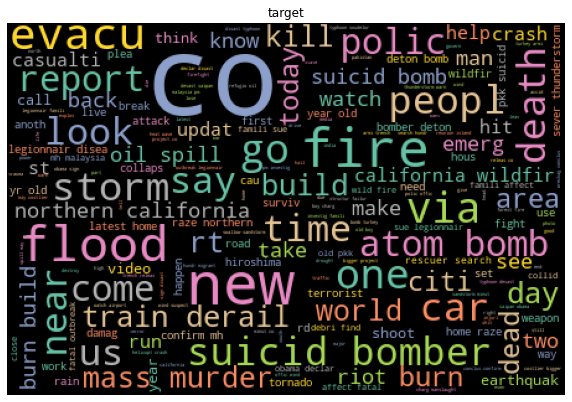

In [41]:
from wordcloud import WordCloud

tags_sent = df_train.loc[df_train['target'] == 1, 'text']
all_words = ' '.join([text for text in tags_sent])
wordcloud = WordCloud(width=450,height=300, 
                      max_font_size=90, random_state=1, 
                      background_color='black', colormap='Set2').generate(all_words)
plt.figure(figsize=(10, 7))   
plt.imshow(wordcloud)
plt.axis('off')
plt.title('target')
plt.show()

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_train['text']).todense()
y = df_train['target'].values

In [43]:
#Split the train data set to train and test data
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2, random_state=2020)
print('Train Data splitted successfully')

Train Data splitted successfully


In [44]:
# Fitting Logistic Regression Model to the Training set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)
# Predicting the Train data set results
y_pred_lr = classifier_lr.predict(X_test)
# Making the Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr

array([[755,  94],
       [195, 479]])

In [45]:
#Calculating Model Accuracy
print('Logistic Regression Model Accuracy Score for Train Data set is {}'.format(classifier_lr.score(X_train, y_train)))
print('Logistic Regression Model Accuracy Score for Test Data set is {}'.format(classifier_lr.score(X_test, y_test)))
print('Logistic Regression Model F1 Score is {}'.format(f1_score(y_test, y_pred_lr)))

Logistic Regression Model Accuracy Score for Train Data set is 0.964696223316913
Logistic Regression Model Accuracy Score for Test Data set is 0.8102429415627052
Logistic Regression Model F1 Score is 0.7682437850842022


In [46]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,happen terribl car crash
1,2,NaN,NaN,hear earthquak differ citi stay safe everyon
2,3,NaN,NaN,forest fire spot pond gee flee across street save
3,9,NaN,NaN,apocalyps light spokan wildfir
4,11,NaN,NaN,typhoon soudelor kill china taiwan


In [53]:
X_final = vectorizer.transform(df_test['text']).todense()

y_final = classifier_lr.predict(X_final)
output = pd.DataFrame({'id': df_test['id'], 'target': y_final})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
